In [1]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy
import sklearn
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Motivation

World-class methods for image classification can be found [here](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354).

# Download Data

In [3]:
from sklearn.model_selection import train_test_split

PATH = '/usr/local/data/digit-recognizer'
#!kaggle competitions download -c digit-recognizer -p {PATH}

train_labels, train = [x.squeeze() for x in np.hsplit(pd.read_csv('{}/train.csv'.format(PATH)).values, [1])]
train_labels, validation_labels, train, validation = train_test_split(train_labels, train, test_size=0.1)

test = pd.read_csv('{}/test.csv'.format(PATH)).values

# Explore Data

## Data Layout

MNIST images are 28x28 8-bit arrays stored as a single length 784 array.

In [5]:
print(train.shape)
print(train.min(), train.max())

(37800, 784)
0 255


## Images

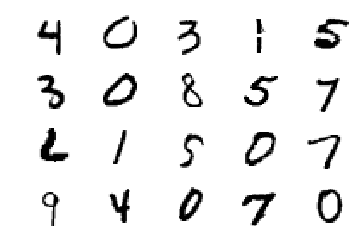

In [6]:
for i in range(0, 20):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(train[i].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation='nearest') 

# Labels

In [7]:
print(train_labels.shape, train_labels[:20])

(37800,) [4 0 3 1 5 3 0 8 5 7 6 1 5 0 7 9 4 0 7 0]


# Prepare Data

## Augment

Add generated images to the data set.

Transformations include shifting left, right, up, and down by 1 pixel.

In [21]:
from PIL import Image
from scipy import stats

def transform(imarray, w=None, h=None, angle=0, dx=0, dy=0, dw=0, dh=0):
    im = Image.fromarray(np.uint8(imarray.reshape(28, 28)))
    size = (w or im.width, h or im.height)
    resized = im.resize(size, Image.BICUBIC, (dw, dh, im.width - dw, im.height - dh))
    rotated = resized.rotate(angle, Image.BICUBIC, translate=(dx, dy))
    data = rotated.getdata()
    return np.array(data)

def augment(X, num_augmentations=4):
    da = stats.randint(-10, 11).rvs
    dxy = stats.randint(-2, 3).rvs
    dwh = stats.randint(0, 3).rvs
    transformations = np.apply_along_axis(lambda x: [transform(x, angle=da(), dx=dxy(), dy=dxy(), dw=dwh(), dh=dwh()) for i in range(0, num_augmentations)], 1, X)
    return np.concatenate([np.expand_dims(X, axis=1), transformations], axis=1).reshape(-1, X.shape[1])


In [7]:
train = augment(train, num_augmentations=3)
train_labels = np.repeat(train_labels, 4)

NameError: name 'augment' is not defined

## Explore Augmented Data

(37800, 784)


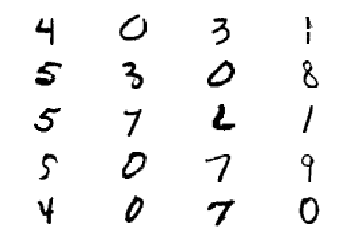

In [8]:
print(train.shape)

for i in range(0, 20):
    plt.subplot(5, 4, i + 1)
    plt.axis('off')
    plt.imshow(train[i].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation='nearest') 

In [9]:
print(train_labels.shape, train_labels[:20])

(37800,) [4 0 3 1 5 3 0 8 5 7 6 1 5 0 7 9 4 0 7 0]


## Transform

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from ml.transformers import ConstantScaler

pipeline = Pipeline([
#    ('trim', FunctionTransformer(lambda X: np.apply_along_axis(lambda x: x.reshape(28, 28)[4:-4,4:-4].reshape(-1), 1, X))),
    ('scale', ConstantScaler(1.0/255)),
#    ('scale', StandardScaler()),
])

train = pipeline.fit_transform(train)
validation = pipeline.transform(validation)

# Model Selection

In [5]:
from importlib import reload
import ml.networks
reload(ml.networks)
from ml.networks import NetworkClassifier, LearningRateFinder, Reshape

## Fully Connected

In [6]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 10),
    nn.Softmax(dim=1)
)
network = NetworkClassifier(model).fit(train, train_labels, validation, validation_labels)
print('Validation Accuracy: {}'.format(network.score(validation, validation_labels)))

HBox(children=(IntProgress(value=0, description='Epoch', max=250), HTML(value='')))

Validation Accuracy: 0.979047619047619


## Convolutional

In [14]:
# N filters, size, stride, padding, pooling
width, height = 28, 28
filters = [
    (32, 5, 1, 0, 2),
    (64, 5, 1, 0, 2)
]
model = nn.Sequential(
    Reshape(-1, 1, width, height),

    # Conv 1
    nn.Conv2d(1, filters[0][0], filters[0][1], filters[0][2], filters[0][3]),
    nn.MaxPool2d(filters[0][4]),
    nn.ReLU(),

    # Conv 2
    nn.Conv2d(filters[0][0], filters[1][0], filters[1][1], filters[1][2], filters[1][3]),
    nn.MaxPool2d(filters[1][4]),
    nn.ReLU(),

    # FC 1
    # TODO: this calculation
    # [0] * 
    # 16*12*12  32*4*4
    Reshape(-1, 1024),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Dropout(),

    # FC 2
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)
network = NetworkClassifier(model, batch_size=128).fit(train, train_labels, train[:1000], train_labels[:1000])
print('Validation Accuracy: {}'.format(network.score(train[1000:2000], train_labels[1000:2000])))

HBox(children=(IntProgress(value=0, description='Epoch', max=250), HTML(value='')))


Validation Accuracy: 0.993


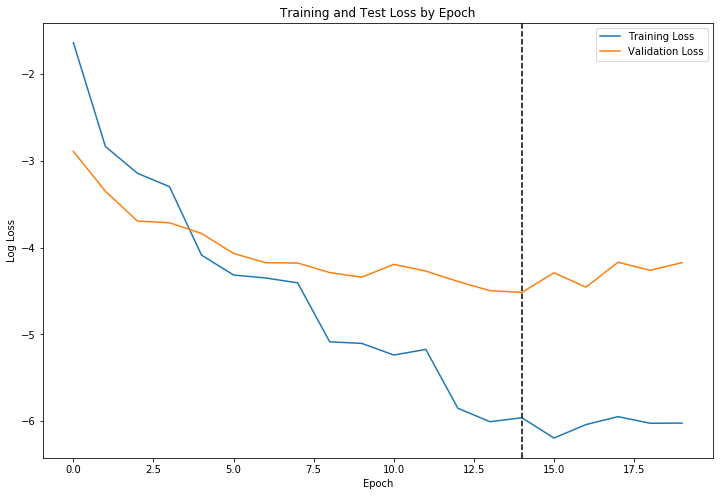

In [15]:
network.plot()

NetworkClassifier uses [Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/abs/1608.03983) as a means
of optimizing the learning rate regime.  The restarts are clearly visible as small bumps in both the training and
validation loss plots.

To prevent overfitting, training is also stopped early if the validation loss ceases to improve.  Given the stochastic nature of the
training process there can be temporary increases in the loss value, so training is stopped only when `n_early_stoppage` epochs have passed without an improvement in the validation loss.

Min LR: 5.84e-04
Max LR: 8.58e-04


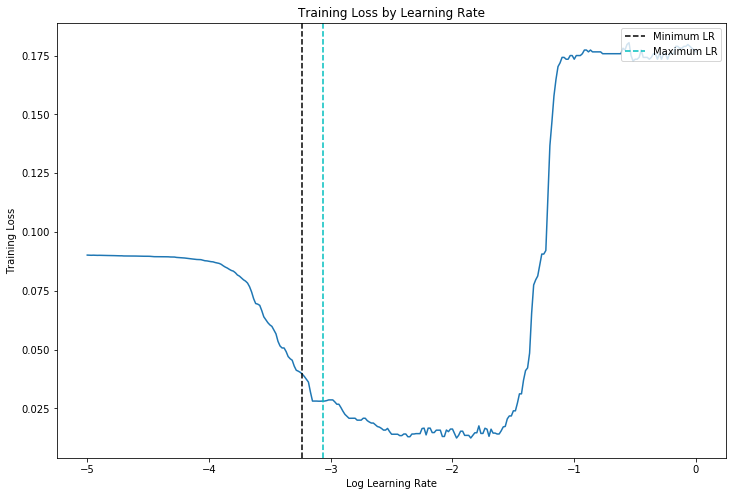

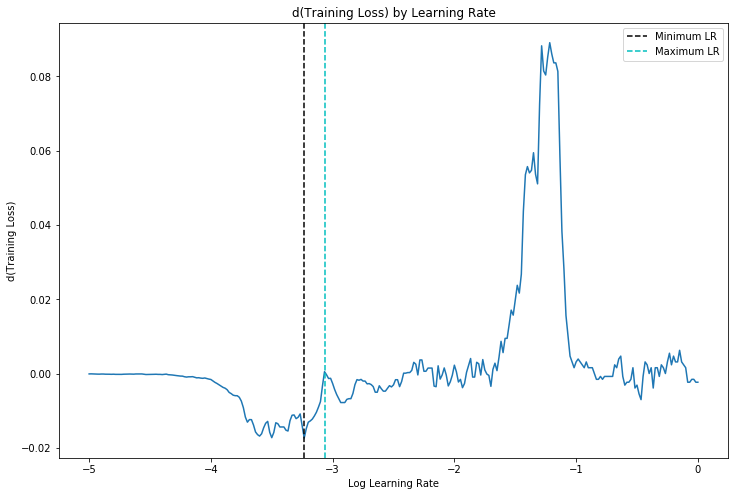

In [16]:
print('Min LR: {:.2e}\nMax LR: {:.2e}'.format(network.learning_rate.min, network.learning_rate.max))
network.learning_rate.plot(type='losses')
network.learning_rate.plot(type='d_losses')

# Test Time Augmentation

In [145]:
def TTA(model, X, num_augmentations=4, split_size=1000):
    predictions = []
    for arr in tqdm(np.array_split(X, np.size(X, 0) / split_size)):
        prepared = pipeline.transform(augment(arr, num_augmentations))
        probs = model.predict_proba(prepared).reshape(-1, num_augmentations + 1, 10).mean(axis=1)
        predictions.append(np.argmax(probs, axis=1))
    return np.hstack(predictions)

# Prediction

In [17]:
final_predictions = np.array([])
for i in range(0, test.shape[0], 1000):
    final_predictions = np.append(final_predictions, network.predict(test[i:i+1000]))
#final_predictions = TTA(network, test, 4, 1000)

# Submission

In [18]:
final_indices = np.arange(1, final_predictions.size + 1)
final_csv = '{}/submissions/pytorch_nn_conv2d_4.csv'.format(PATH)
np.savetxt(final_csv, np.array([final_indices, final_predictions]).transpose(), fmt='%d', header='ImageId,Label', comments='', delimiter=',')

In [19]:
# TODO: put in /usr/local/lib/ml/util
# TODO: refactor download and baseline submission cells to use utility functions

def download(competition, path):
    !kaggle competitions download -c "{competition}" -p "{path}"

def submit(competition, file, message):
    !kaggle competitions submit -c "{competition}" -f "{file}" -m "{message}"

submit('digit-recognizer', final_csv, 'pytorch neural network with two slightly larger convolutional layers')

Successfully submitted to Digit Recognizer